In [1]:
import argparse
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import time
%matplotlib inline
print("OpenCV Version : %s " % cv2.__version__)

def rotate(image, angle, scale=1.0):
    """Rotate image by angle and scale"""
    h, w = image.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    # fill in 255 (white) as border during rotation
    rotated = cv2.warpAffine(image, M, (w, h), borderValue=255)
    return rotated

def pad(image, h_margin=100, w_margin=100):
    """Pad 2D image by `margin` pixels on four sides"""
    assert len(image.shape) == 2, 'Image is not 2D!'
    h, w = image.shape
    print(h, w)
    padded = np.ones((h + 2 * h_margin, w + 2 * w_margin), dtype='uint8') * 255
    padded[h_margin : (h_margin + h), w_margin : (w_margin + w)] = image
    return padded


def order_points(pts):
    """Reorder an array of 4 coordinates.

    The reordered list is in the order of top-left, top-right, 
    bottom-right, and bottom-left.
    """
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # the top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    """Perspective transformation a region of interest in image"""

    # reorder the points first
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # construct destination canvas
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

def find_bounding_box(image, 
    morph_size=(10, 1), 
    iterations=4, 
    threshold=200, 
    roi_range=[], 
    padding=0, 
    angle=0,
    save_image=0,
    open_size=[]):
    if roi_range:
        # crop region of interest
        roi = image[roi_range[0]:roi_range[1], roi_range[2]:roi_range[3]]
    else:
        roi = image
    

    print(roi.shape)
    # rotation
    rotated = rotate(roi, angle)

    # tresholding
    # if pixel > 200, then map to 255 (white); otherwise map to 0
    (T, thresh) = cv2.threshold(rotated, threshold, 255, cv2.THRESH_BINARY)

    # opening
    if open_size:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, open_size)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    else:
        opening = thresh

    # pad and inversion
    if padding:
        padded = pad(opening)
    else:
        padded = opening
    inverted = 255 - padded

    # morph
    struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    dilated = cv2.dilate(inverted.copy(), struct_elem, iterations=iterations)

    # thresholding
    (T, thresh2) = cv2.threshold(dilated, threshold, 255, cv2.THRESH_BINARY)

    # debug: watershed

    # find the contours in the thresholded image, then sort the contours
    # by their area, keeping only the largest one
    im2, cnts, hierarchy = cv2.findContours(thresh2.copy().astype(np.uint8), 
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = [cnt for cnt in cnts if cv2.contourArea(cnt) > 500]

    if save_image:
        cv2.imwrite('0.original.jpg', image)
        cv2.imwrite('1.roi.jpg', roi)
        cv2.imwrite('2.rotated.jpg', rotated)
        cv2.imwrite('3.thresh.jpg', thresh)
        cv2.imwrite('4.padded.jpg', padded)
        cv2.imwrite('5.inverted.jpg', inverted)
        cv2.imwrite('6.dilated.jpg', dilated)
        cv2.imwrite('7.thresh2.jpg', thresh2)
    
    # return padded rotated gray image and contours        
    if padding:
        return pad(rotated), cnts
    else:
        return rotated, cnts


OpenCV Version : 2.4.10 


In [35]:
# # get image file from command line
# ap = argparse.ArgumentParser()
# ap.add_argument('--image', required=True, help='Path to input image')
# ap.add_argument('--save', action='store_true', help='Flag to save images')
# args = ap.parse_args()
# filename = args.image
# if args.save:
#     save_image = True
# else:
#     save_image = False
filename = r'./testImages/1000967244029_3007_1.jpg'
filename = r'./testImages/1000968571699_3007_2.jpg'
filename = r'./testImages/1000992520057_3007_1.jpg'
filename = r'./testImages/1000995056687_3007_1.jpg'


assert os.path.isfile(filename), 'file does not exist!'



### Adaptive thresholding

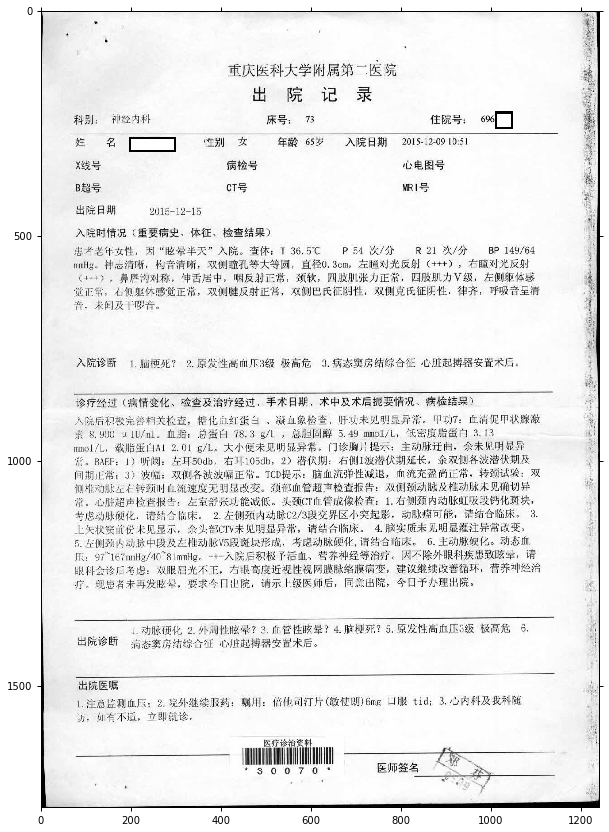

In [36]:
image = cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
matplotlib.rcParams['figure.figsize'] = (10.0, 20.0) 
plt.imshow(gray, cmap='gray')



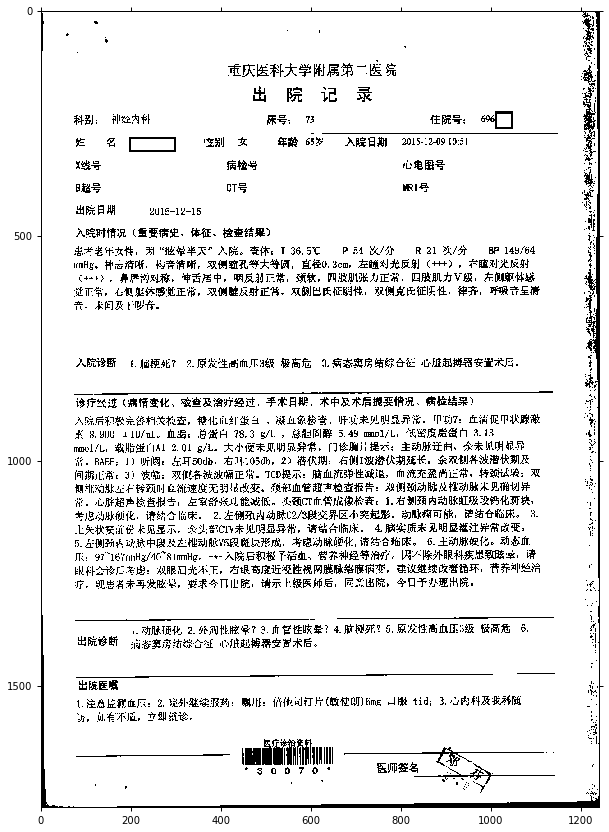

In [37]:
(T, thresh) = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

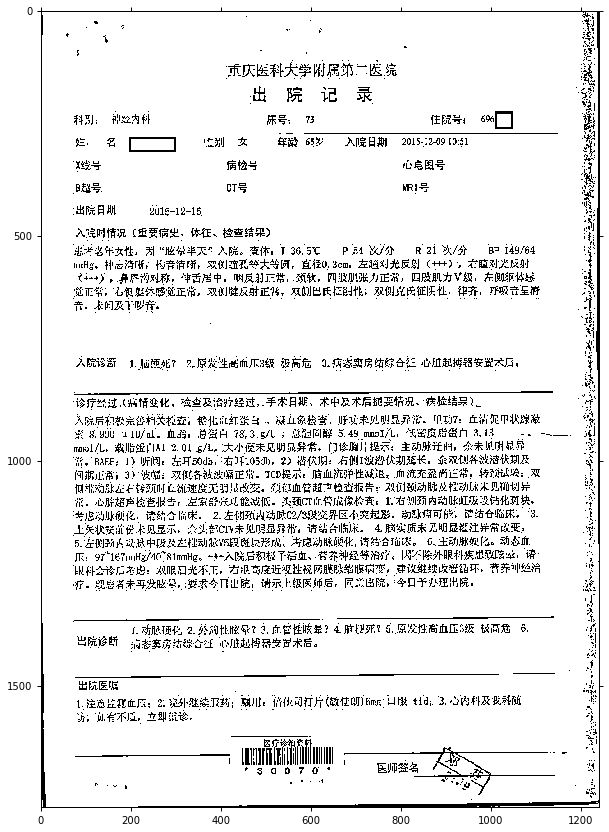

In [38]:
thresh = cv2.adaptiveThreshold(gray, 255, 
    cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 10)
plt.imshow(thresh, cmap='gray')

In [39]:
# crop and warp main text region
canvas, cnts = find_bounding_box(thresh,
    morph_size=(20, 20), 
    iterations=4,
    save_image=1,
    threshold=128)

canvas_clean = canvas.copy()
c = sorted(cnts, key=cv2.contourArea, reverse=True)

rect = cv2.minAreaRect(c[0])
box = np.int0(cv2.boxPoints(rect))
cv2.drawContours(canvas, [box], -1, 0, 3)
line = four_point_transform(canvas_clean, box)
matplotlib.rcParams['figure.figsize'] = (5.0, 10.0) 
plt.imshow(canvas, cmap='gray')
# cv2.imshow('Boxed Mainbody', canvas)

(1768, 1240)


ValueError: need more than 2 values to unpack

In [3]:
image = cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# crop and warp main text region
canvas, cnts = find_bounding_box(gray,
    morph_size=(20, 20), 
    iterations=4,
    save_image=1,
    threshold=128)

canvas_clean = canvas.copy()
c = sorted(cnts, key=cv2.contourArea, reverse=True)

rect = cv2.minAreaRect(c[0])
box = np.int0(cv2.boxPoints(rect))
cv2.drawContours(canvas, [box], -1, 0, 3)
line = four_point_transform(canvas_clean, box)
matplotlib.rcParams['figure.figsize'] = (5.0, 10.0) 
plt.imshow(canvas, cmap='gray')
# cv2.imshow('Boxed Mainbody', canvas)



(1760, 1158)


ValueError: need more than 2 values to unpack

In [4]:
warped = four_point_transform(canvas_clean, box)
plt.imshow(warped, cmap='gray')
# cv2.imshow('Warped', warped)
# cv2.waitKey(0)
# if save_image:
#     cv2.imwrite('8.boxed_mainbody.jpg', canvas)
#     cv2.imwrite('9.warped.jpg', warped)


NameError: name 'canvas_clean' is not defined

In [332]:

def find_bounding_box_line(image, 
    morph_size=(10, 1), 
    iterations=4, 
    threshold=200, 
    roi_range=[], 
    padding=0, 
    angle=0,
    save_image=0,
    delineate=0,
    open_size=[]):
    if roi_range:
        # crop region of interest
        roi = image[roi_range[0]:roi_range[1], roi_range[2]:roi_range[3]]
    else:
        roi = image
    

    print(roi.shape)
    # rotation
    rotated = rotate(roi, angle)

    # tresholding
    # if pixel > 200, then map to 255 (white); otherwise map to 0
    (T, thresh) = cv2.threshold(rotated, threshold, 255, cv2.THRESH_BINARY)

    # opening
    if open_size:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, open_size)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    else:
        opening = thresh

    # pad and inversion
    if padding:
        padded = pad(opening)
    else:
        padded = opening
    inverted = 255 - padded

    # morph
    struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    dilated = cv2.dilate(inverted.copy(), struct_elem, iterations=iterations)

    # thresholding
    (T, thresh2) = cv2.threshold(dilated, threshold, 255, cv2.THRESH_BINARY)

    # filter out thin lines
    thresh2 = cv2.medianBlur(thresh2, 9)

    # delineate each line
    if delineate:
        profile = np.sum(thresh2, axis=1)
        profile = (profile / np.max(profile) * 255).astype(np.uint8)
        profile_img = np.array([profile, profile])
        minima_window = cv2.adaptiveThreshold(profile_img, 255, 
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 51, 10)
        minima_window = minima_window[1, :]

        x1 = np.where(np.diff(minima_window.astype(np.float)) > 0)[0]
        x2 = np.where(np.diff(minima_window.astype(np.float)) < 0)[0]
        # clean border area
        if x1[0] > x2[0]:
            x2 = x2[1:]
        if x1[-1] > x2[-1]:
            x1 = x1[1:]
        assert len(x1) == len(x2)

        minima = []
        for i in range(len(x1)):
            if np.min(profile[x1[i]:x2[i]]) > 0:
                minima.append(np.argmin(profile[x1[i]:x2[i]]) + x1[i])

        delineated = thresh2.copy()
        for pt in minima:
            delineated[pt-5:pt+5, :] = 0
    else:
        delineated = thresh2.copy()

    # find the contours in the thresholded image, then sort the contours
    # by their area, keeping only the largest one
    im2, cnts, hierarchy = cv2.findContours(delineated.copy().astype(np.uint8), 
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = [cnt for cnt in cnts if cv2.contourArea(cnt) > 500]

    if save_image:
        cv2.imwrite('0.original.jpg', image)
        cv2.imwrite('1.roi.jpg', roi)
        cv2.imwrite('2.rotated.jpg', rotated)
        cv2.imwrite('3.thresh.jpg', thresh)
        cv2.imwrite('4.padded.jpg', padded)
        cv2.imwrite('5.inverted.jpg', inverted)
        cv2.imwrite('6.dilated.jpg', dilated)
        cv2.imwrite('7.thresh2.jpg', thresh2)
        cv2.imwrite('8.delineated.jpg', delineated)
    
    # return padded rotated gray image and contours        
    if padding:
        return pad(rotated), cnts, delineated
    else:
        return rotated, cnts, delineated
    


(1535, 1012)


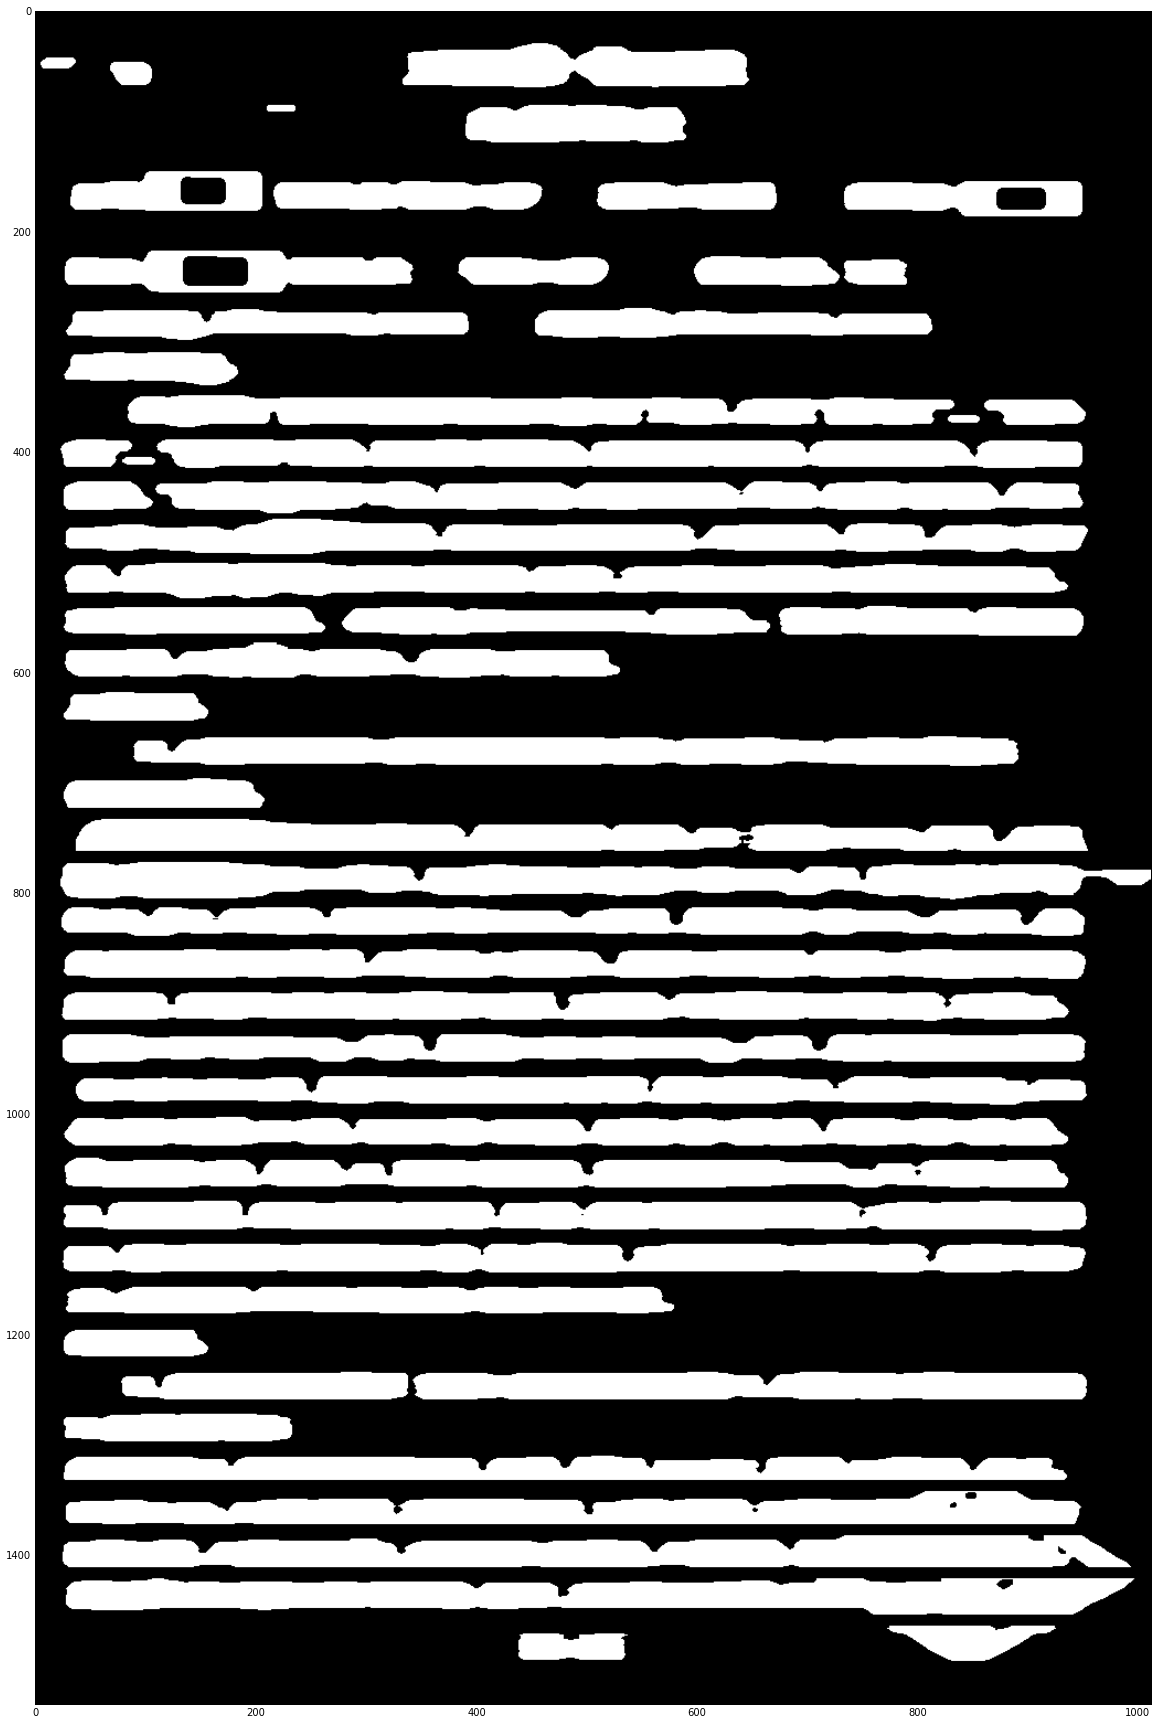

In [335]:

# crop and warp each line
# canvas, cnts, thresh2 = find_bounding_box_line(warped[1000:, :], 
canvas, cnts, delineated = find_bounding_box_line(warped, 
    morph_size=(10, 1), 
    iterations=3, 
    padding=0,
    save_image=1,
    delineate=1)
#     open_size=(3, 3))
matplotlib.rcParams['figure.figsize'] = (20.0, 40.0) 
plt.imshow(delineated, cmap='gray')

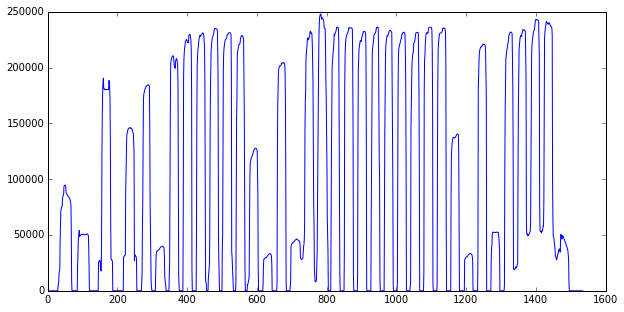

In [315]:
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) 
profile = np.sum(thresh2, axis=1)
plt.plot(profile)

# plt.plot(np.diff(np.sum(thresh2, axis=1)))

In [316]:
profile = (profile / np.max(profile) * 255).astype(np.uint8)
profile_img = np.array([profile, profile])

In [317]:
profile_img.shape

(2, 1535)

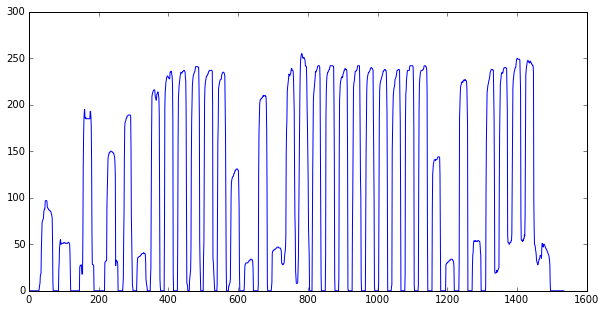

In [318]:
plt.plot(profile)

In [319]:
minima_window = cv2.adaptiveThreshold(profile_img, 255, 
    cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 51, 10)
minima_window = minima_window[1, :]

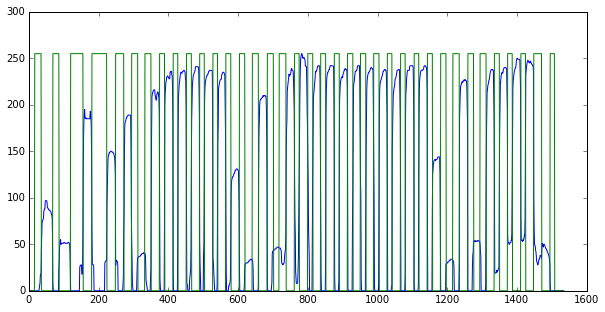

In [320]:
plt.plot(profile)
plt.plot(minima_window)
# plt.xlim((600, 2000))

In [321]:
x1 = np.where(np.diff(mask.astype(np.float)) > 0)[0]
x2 = np.where(np.diff(mask.astype(np.float)) < 0)[0]
# clean border area
if x1[0] > x2[0]:
    x2 = x2[1:]
if x1[-1] > x2[-1]:
    x1 = x1[1:]

assert len(x1) == len(x2)

In [322]:
minima = []
for i in range(len(x1)):
    if np.min(profile[x1[i]:x2[i]]) > 0:
        minima.append(np.argmin(profile[x1[i]:x2[i]]) + x1[i])

In [323]:
minima

[728, 767, 1337, 1377, 1416, 1459]

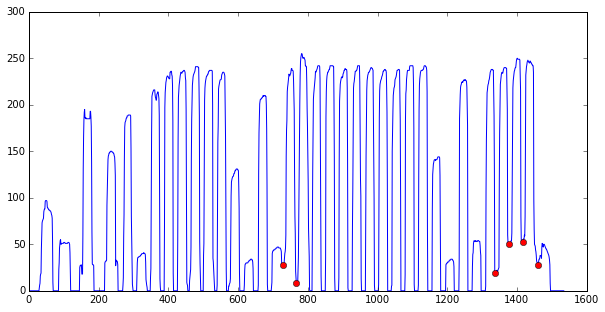

In [324]:
plt.plot(profile_list)
for pt in minima:
    plt.plot(pt, profile_list[pt], 'ro')

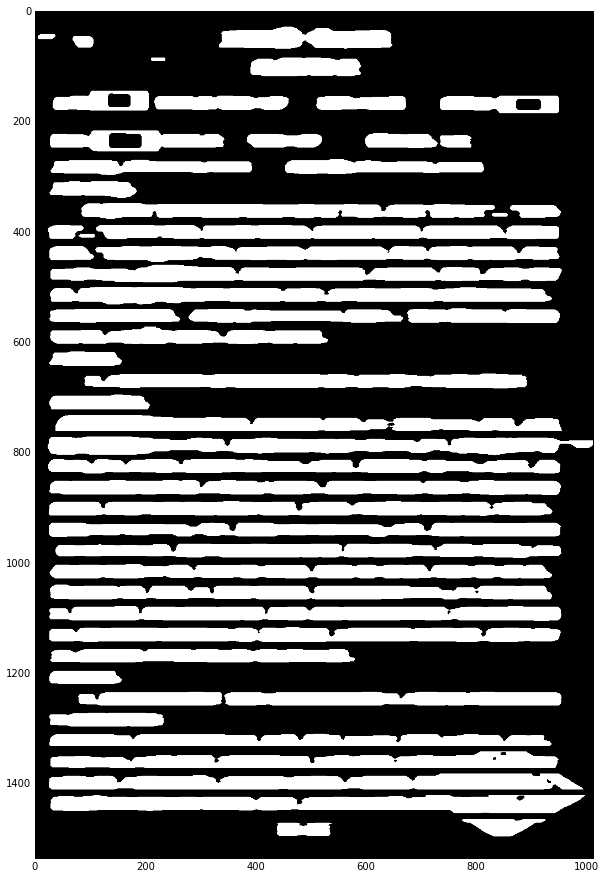

In [325]:
thresh3 = thresh2.copy()
for pt in minima:
    thresh3[pt-5:pt+5, :] = 0
matplotlib.rcParams['figure.figsize'] = (10.0, 20.0) 
plt.imshow(thresh3, cmap='gray')

In [326]:
im2, cnts, hierarchy = cv2.findContours(thresh3.copy().astype(np.uint8), 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = [cnt for cnt in cnts if cv2.contourArea(cnt) > 500]


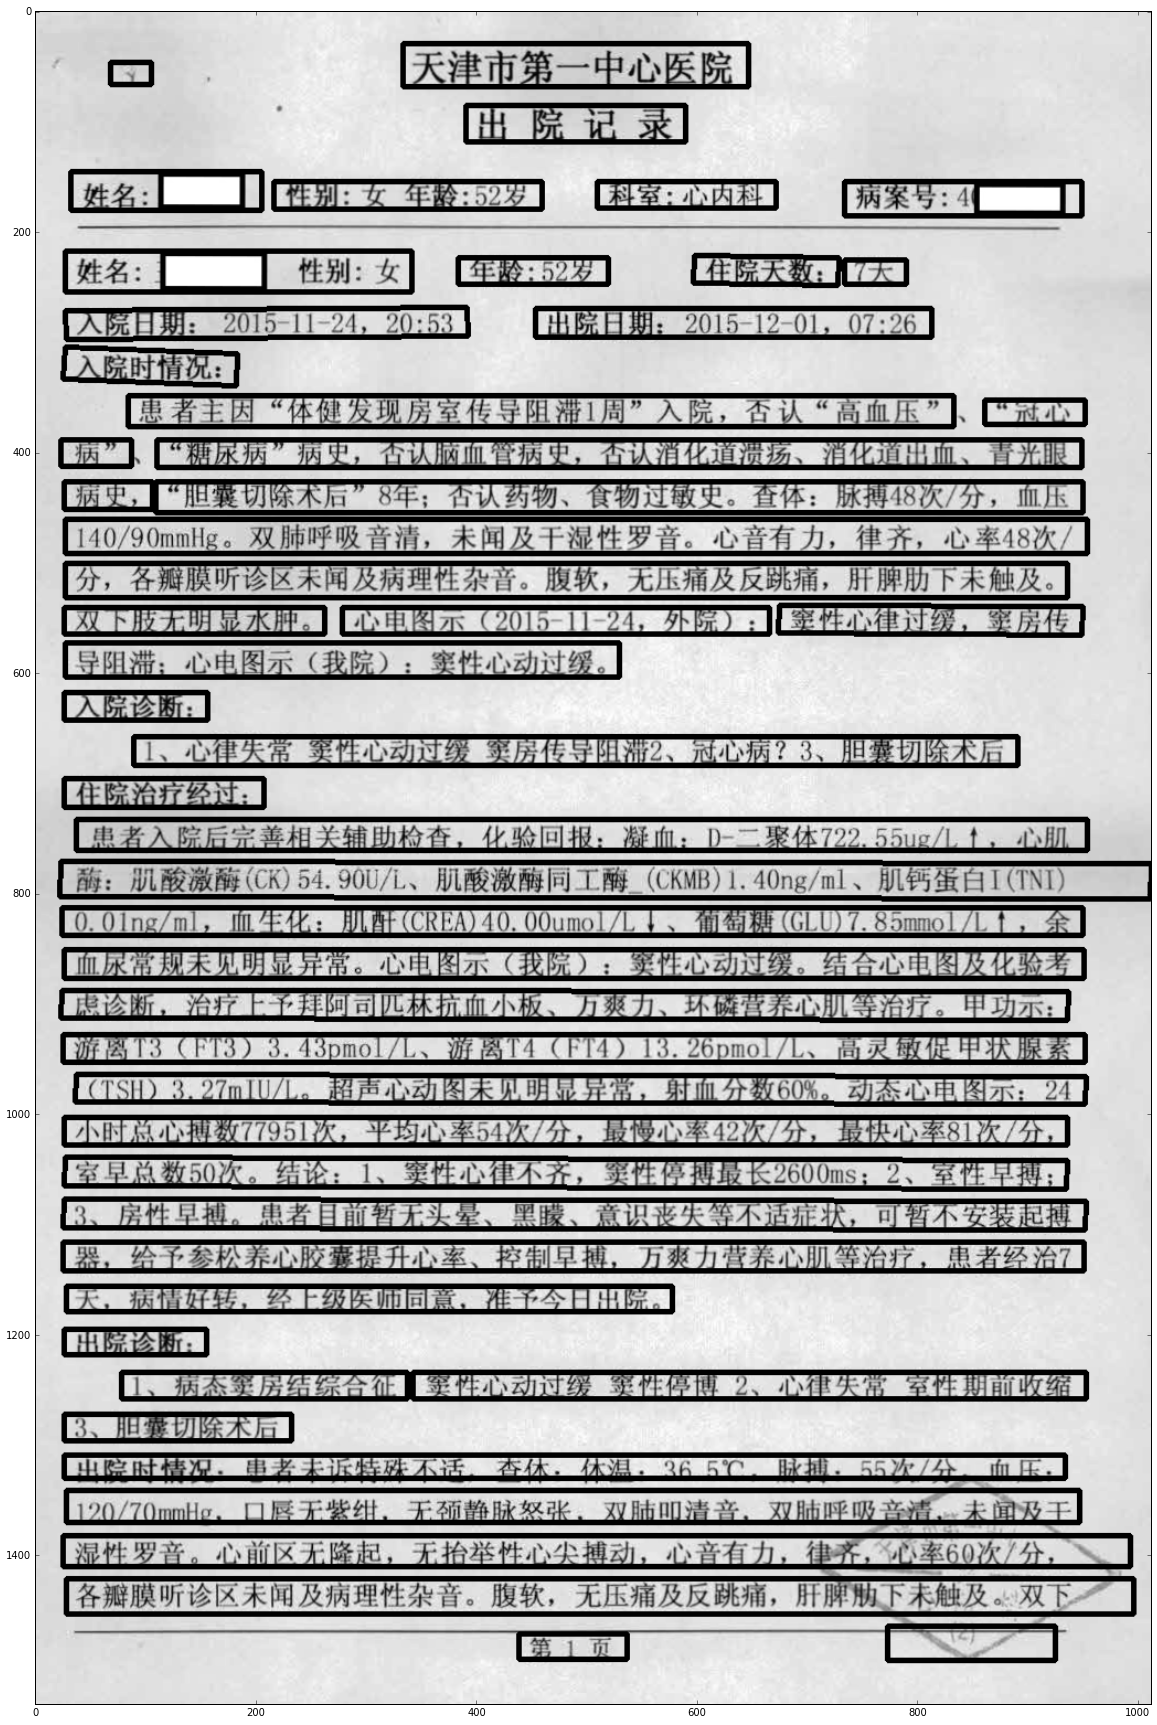

In [328]:
canvas_clean = canvas.copy()
# compute and draw bounding box
c = sorted(cnts, key=cv2.contourArea, reverse=True)
for i in range(len(c)):
    rect = cv2.minAreaRect(c[i])
    box = np.int0(cv2.boxPoints(rect))
    cv2.drawContours(canvas, [box], -1, 0, 3)

matplotlib.rcParams['figure.figsize'] = (20.0, 40.0) 
plt.imshow(canvas, cmap='gray')

(535, 1012)


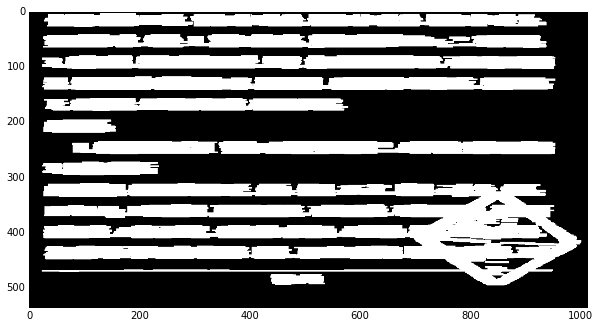

In [33]:

# crop and warp each line
canvas, cnts, thresh2 = find_bounding_box_line(warped[1000:, :], 
    morph_size=(10, 1), 
    iterations=3, 
    padding=0,
    save_image=1,
    open_size=(3, 3))
plt.imshow(thresh2, cmap='gray')

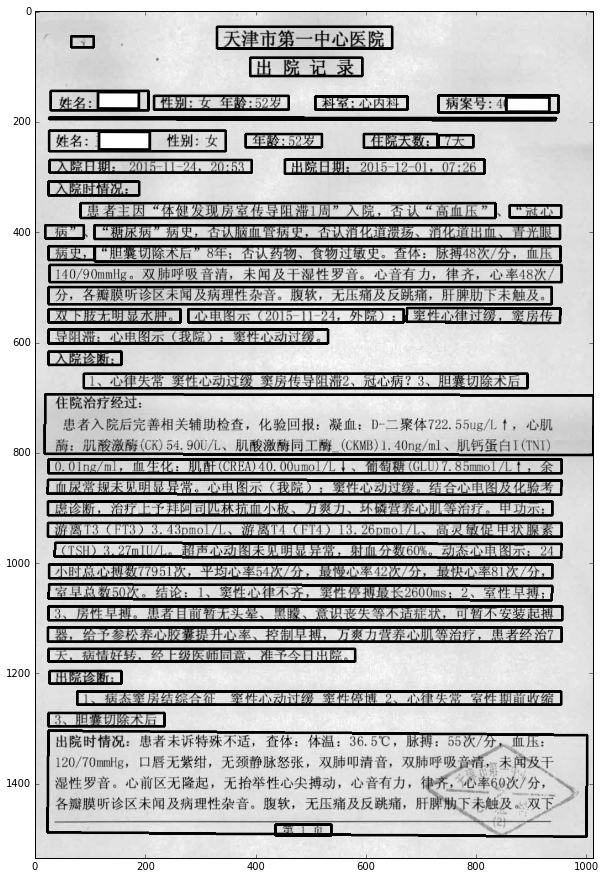

In [64]:

canvas_clean = canvas.copy()
# compute and draw bounding box
c = sorted(cnts, key=cv2.contourArea, reverse=True)
for i in range(len(c)):
    rect = cv2.minAreaRect(c[i])
    box = np.int0(cv2.boxPoints(rect))
    cv2.drawContours(canvas, [box], -1, 0, 3)
    line = four_point_transform(canvas_clean, box)
    # cv2.imshow('Line', pad(line, 5, 5))    
    # cv2.waitKey(0)
    # time.sleep(0.25) 

h, w = canvas.shape
plt.imshow(cv2.resize(canvas, (w , h )), cmap='gray')
matplotlib.rcParams['figure.figsize'] = (10.0, 20.0) 
# cv2.imshow('Boxed Lines', cv2.resize(canvas, (w // 2, h // 2)))
# cv2.waitKey(0)
# if save_image:
#     cv2.imwrite('10.boxed_lines.jpg', canvas)